In [1]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *

In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1022 09:22:01.706465 139803285759808 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1022 09:22:01.738065 139803285759808 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 09:22:01.741313 139803285759808 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1022 09:22:01.742597 139803285759808 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [32]:
score_type = 'fm'

def build_hists_thres(x, n_max, thres, preselect, batch_size=2 ** 20):
    hist_builder_all = HistogramBuilder(settings_6021)
    hist_builder_anomalous = HistogramBuilder(settings_6021)

    n = x.shape[0]
    n = min(n, n_max)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))

        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_batch = x[ran_from:ran_to]
        
        # preselection
        if preselect:
            #filter_iso = x_batch[:,7]+x_batch[:,8]+x_batch[:,9] < 0.15
            filter_eta = np.abs(x_batch[:,5]) < 1.4
            filter_njets = x_batch[:,2] > 1

            filter_idx = filter_njets * filter_eta #filter_iso * filter_eta * filter_njets
            x_batch = x_batch[filter_idx]
        
        hist_builder_all.add_data(x_batch)
        
        # run ad
        x_batch_transformed = preprocessor.transform(x_batch)
        scores = ad.get_anomaly_scores(x_batch_transformed, type=score_type)
        anomaly_idx = scores >= thres
        
        #postselection
        anomaly_idx  = anomaly_idx * x_batch[:,3] > 1
        
        hist_builder_anomalous.add_data(x_batch[anomaly_idx])
        
    return hist_builder_all.get_histogram_data(), hist_builder_anomalous.get_histogram_data()
    

In [33]:
n_max = int(10e6)
preselect = True
thres = 110

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/7719/data.hdf5', 'xsec':561, 'K':1.23}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/7721/data.hdf5', 'xsec':181, 'K':1.23}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/7722/data.hdf5', 'xsec':51, 'K':1.23}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/7723/data.hdf5', 'xsec':15, 'K':1.23}

sets['w1jets'] = {'file': '/home/oliverkn/pro/9863/data.hdf5', 'xsec':4480, 'K':1.23}
sets['w2jets'] = {'file': '/home/oliverkn/pro/9864/data.hdf5', 'xsec':1435, 'K':1.23}
sets['w3jets'] = {'file': '/home/oliverkn/pro/9865/data.hdf5', 'xsec':304, 'K':1.23}

sets['ttbar'] = {'file': '/home/oliverkn/pro/9588/data.hdf5', 'xsec':164, 'K':1.66}

for key, set in sets.items():
    file = set['file']
    print('building ' + key)
    
    x = h5py.File(file, 'r')['data']
    hist, hist_a = build_hists_thres(x, n_max=n_max, thres=thres, preselect = preselect)
    
    n_events = hist['HT']['n']
    n_events_a =hist_a['HT']['n']
    
    set['n_tot'] = x.shape[0]
    set['hist'] = hist
    set['hist_a'] = hist_a
    
    print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))

building dy1jets
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
126 / 5328598 =  23_ppm
building dy2jets
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
49 / 3687605 =  13_ppm
building dy3jets
batch number 0
batch number 1
batch number 2
batch number 3
73 / 1984426 =  36_ppm
building dy4jets
batch number 0
batch number 1
325 / 1180864 = 275_ppm
building w1jets
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
102 / 2686580 =  37_ppm
building w2jets
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
110 / 3487241 =  31_ppm
building w3jets
batch number 0
batch number 1
batch number 2
batch number 3
78 / 1903590 =  40_ppm
building ttbar
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6

In [34]:
n_max = int(10e6)
# data
print('building data')
file = '/home/oliverkn/pro/6021/data.hdf5'

x = h5py.File(file, 'r')['data']
data_hist, data_hist_a = build_hists_thres(x, n_max=n_max, thres=thres, preselect = preselect)
n_events = data_hist['HT']['n']
n_events_a =data_hist_a['HT']['n']
print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))

building data
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
233 / 3359513 =  69_ppm


In [35]:
# compute weights for pdfs
weights_init = []
weights_pres = []
weights_a = []

weights_a = []
for key, set in sets.items():
    n_a = set['hist_a']['HT']['n']
    n_pres = set['hist']['HT']['n']
    n_tot = set['n_tot']
    k = set['K']
    xsec = set['xsec']
    
    w_init = xsec * k
    w_pres = w_init * n_pres/n_tot
    w_a = w_init * n_a/n_tot
    
    weights_init.append(w_init)
    weights_pres.append(w_pres)
    weights_a.append(w_a)

weights_init = np.array(weights_init)
weights_pres = np.array(weights_pres)
weights_a = np.array(weights_a)

# normalizing weights
weights_init = weights_init/np.sum(weights_init)
weights_pres = weights_pres/np.sum(weights_pres)
weights_a = weights_a/np.sum(weights_a)

print(weights_init)
print(weights_pres)
print(weights_a)

[0.0773971  0.02497126 0.0070361  0.00206944 0.61807312 0.19797655
 0.04194068 0.03053576]
[0.04612946 0.03000812 0.00868214 0.00256073 0.58444322 0.22631441
 0.05186037 0.05000153]
[0.0061507  0.00224843 0.00180096 0.00397408 0.12512123 0.0402542
 0.01198244 0.80846798]


saving fig to hist_a.pdf


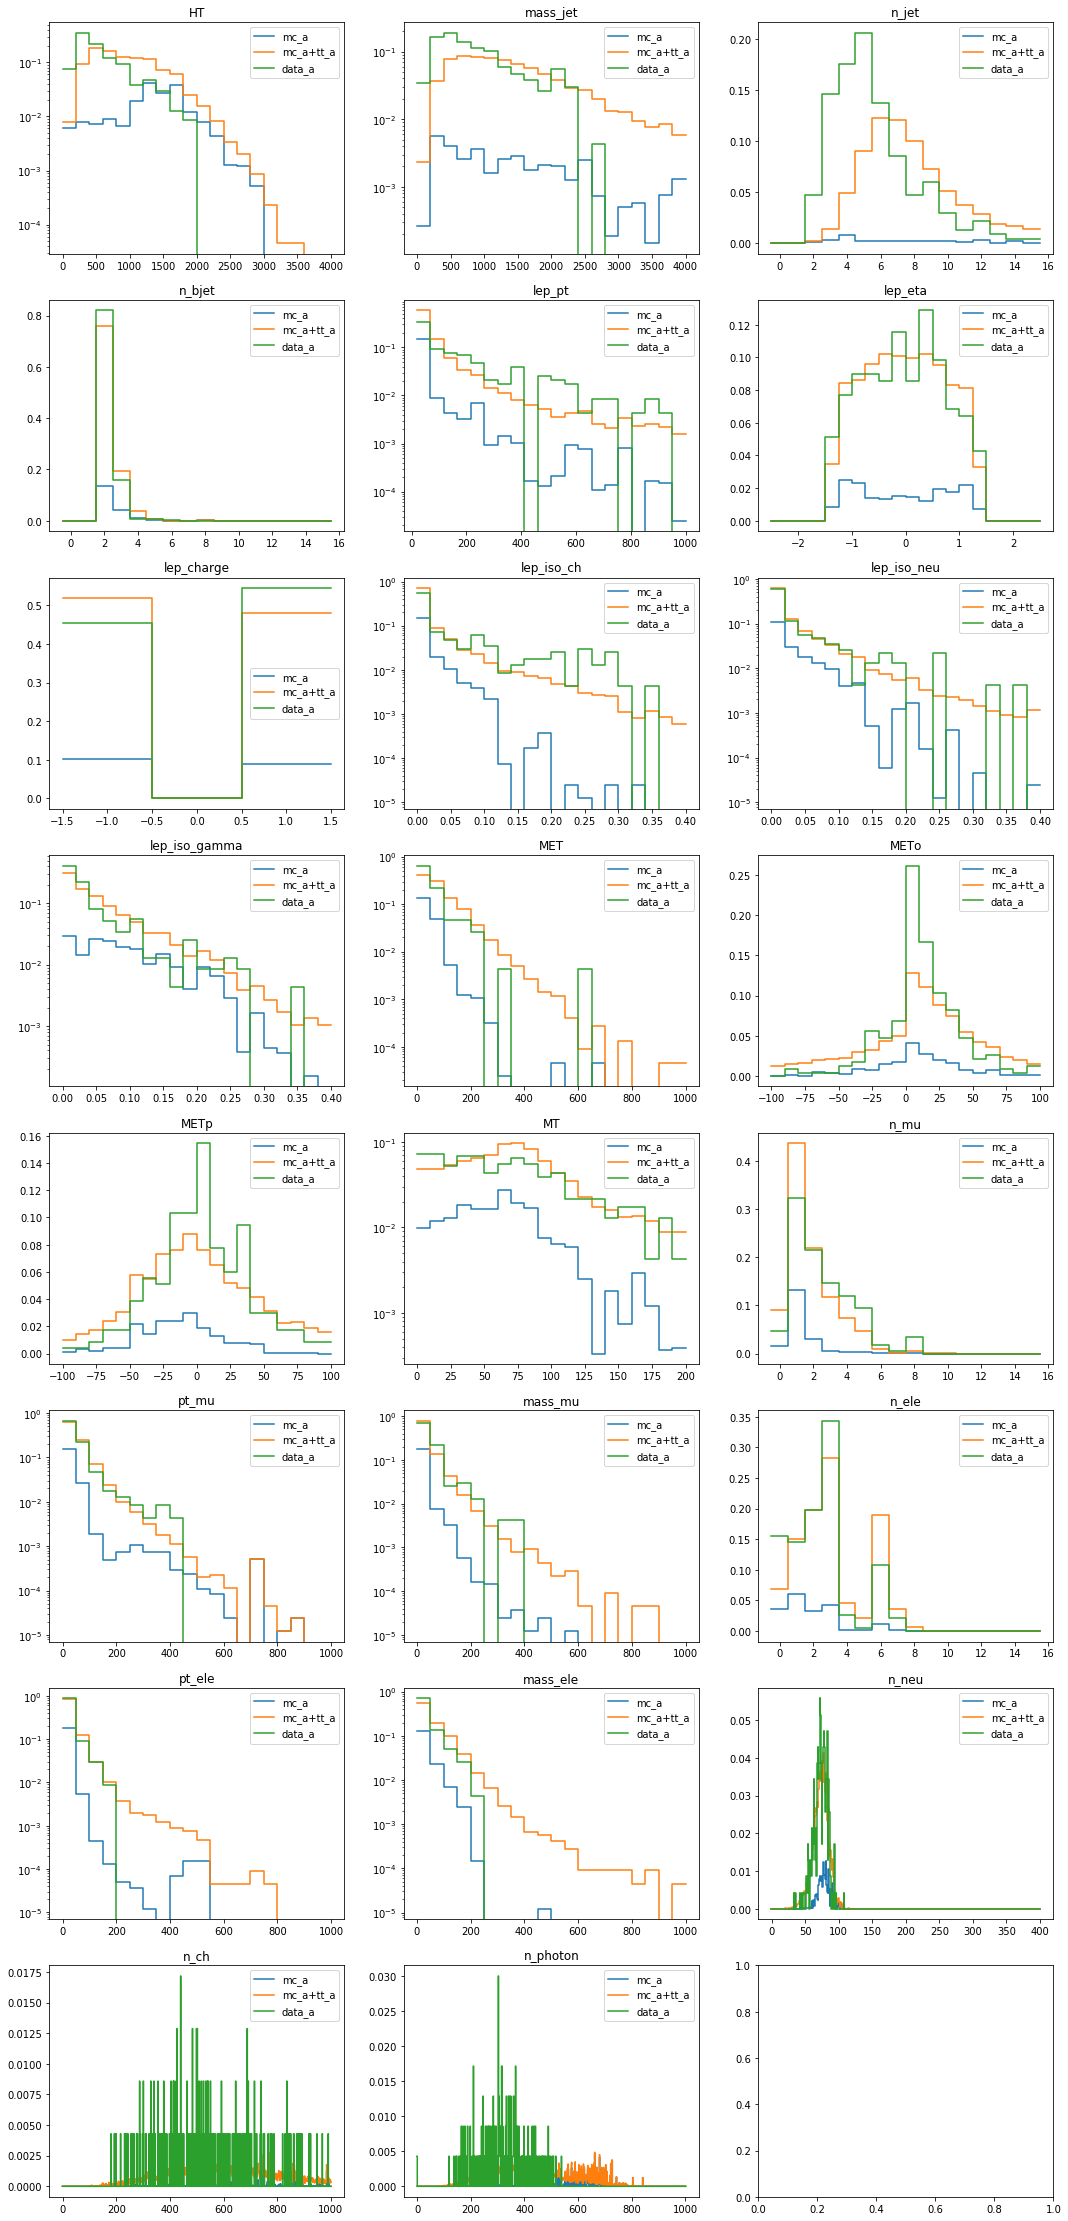

In [36]:
# mc_a
mc_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets']
mc_hist_a_list = [sets[key]['hist_a'] for key in mc_key_list]
mc_hist_a = sum_hists(mc_hist_a_list, weights_a[:-1])
# mc_a + ttbar_a
mc_ttbar_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets', 'ttbar']
mc_ttbar_hist_a_list = [sets[key]['hist_a'] for key in mc_ttbar_key_list]
mc_ttbar_hist_a = sum_hists(mc_ttbar_hist_a_list, weights_a)

plot_hist([mc_hist_a, mc_ttbar_hist_a, data_hist_a], ['mc_a', 'mc_a+tt_a', 'data_a'], settings_6021, output_file='hist_a.pdf')

saving fig to hist_a_detailed.pdf


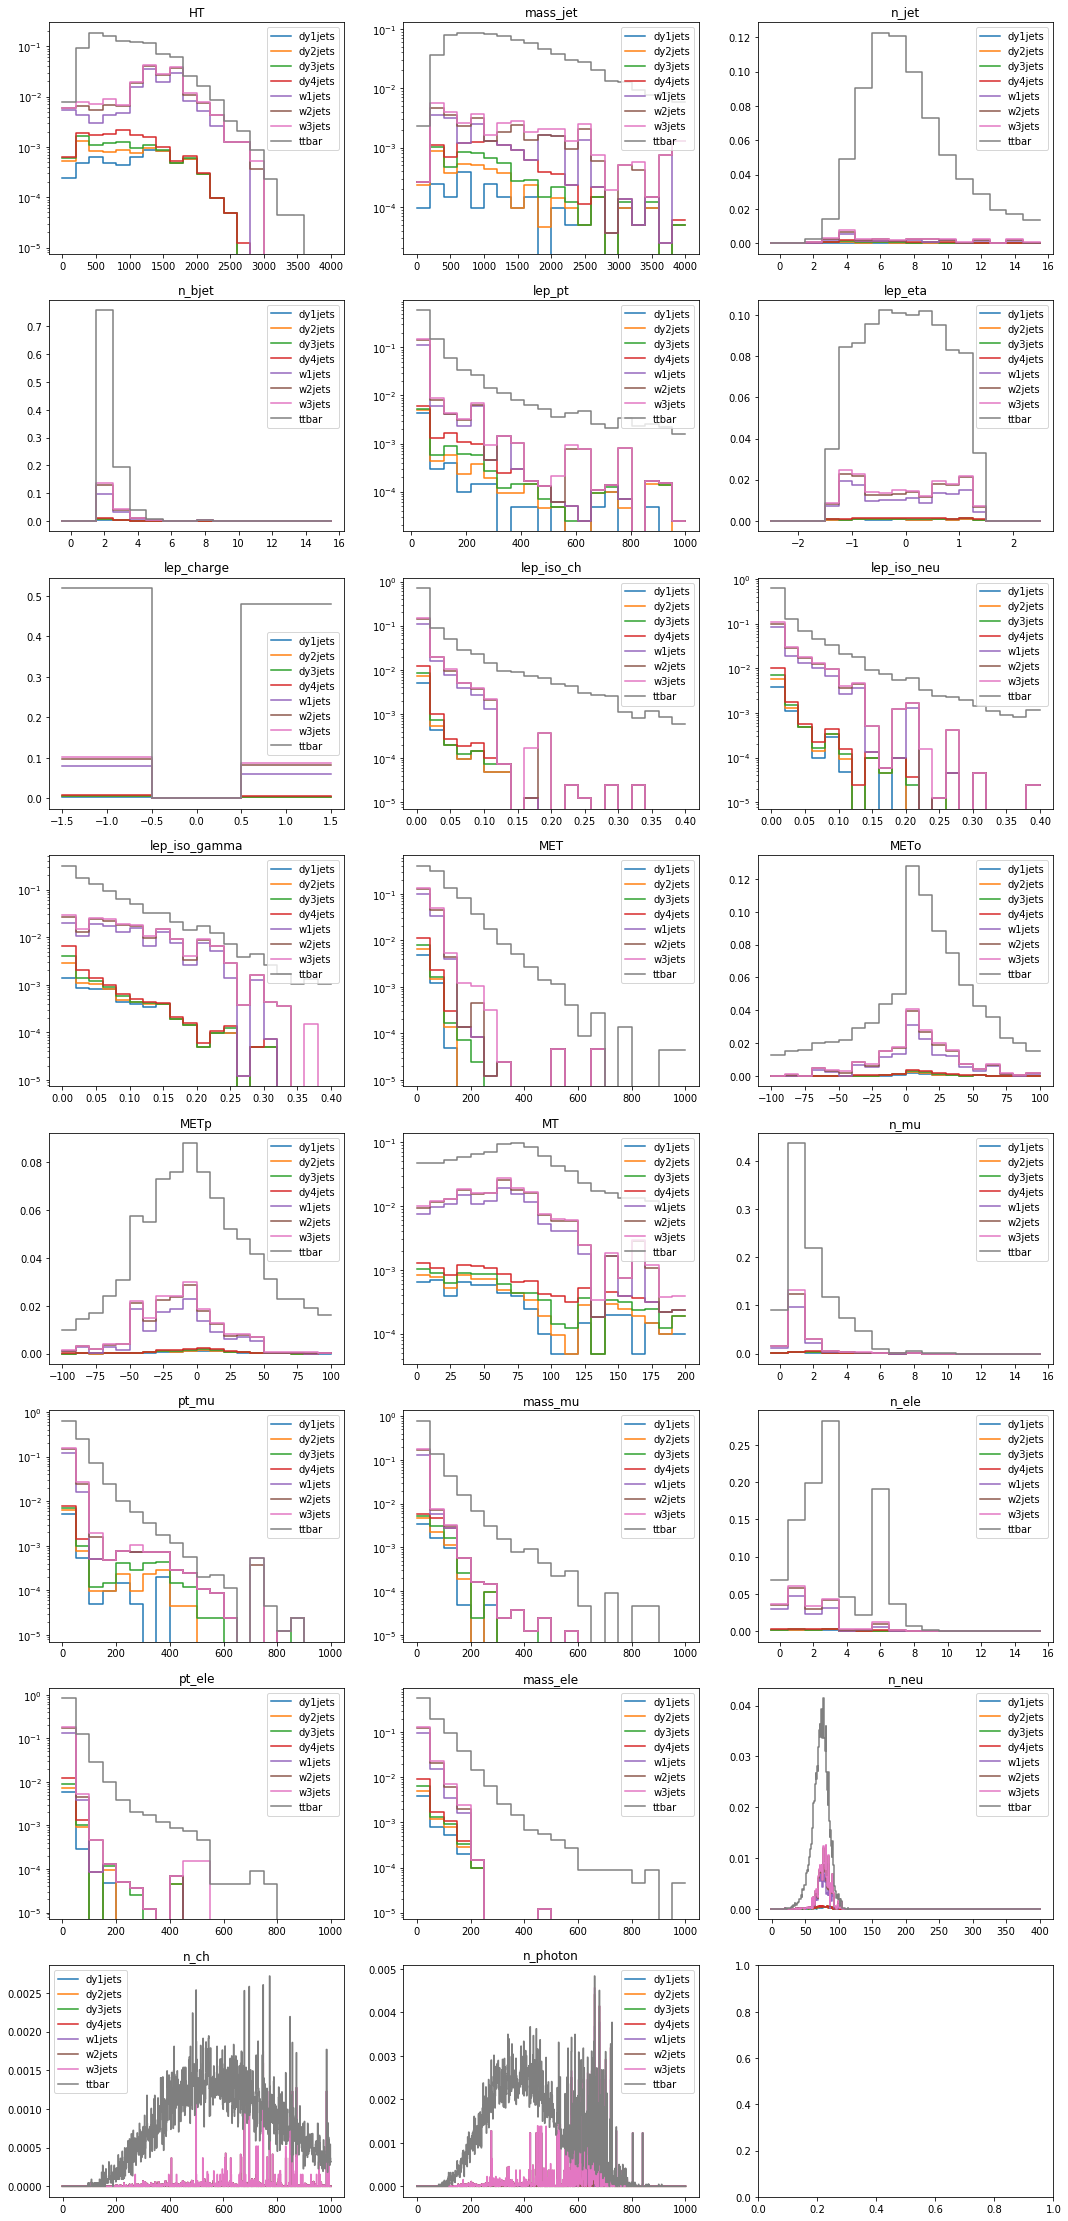

In [37]:
plot_stacked_hist(mc_ttbar_hist_a_list, mc_ttbar_key_list, weights_a, settings_6021, output_file='hist_a_detailed.pdf')

saving fig to hist_a_detailed_nostack.pdf


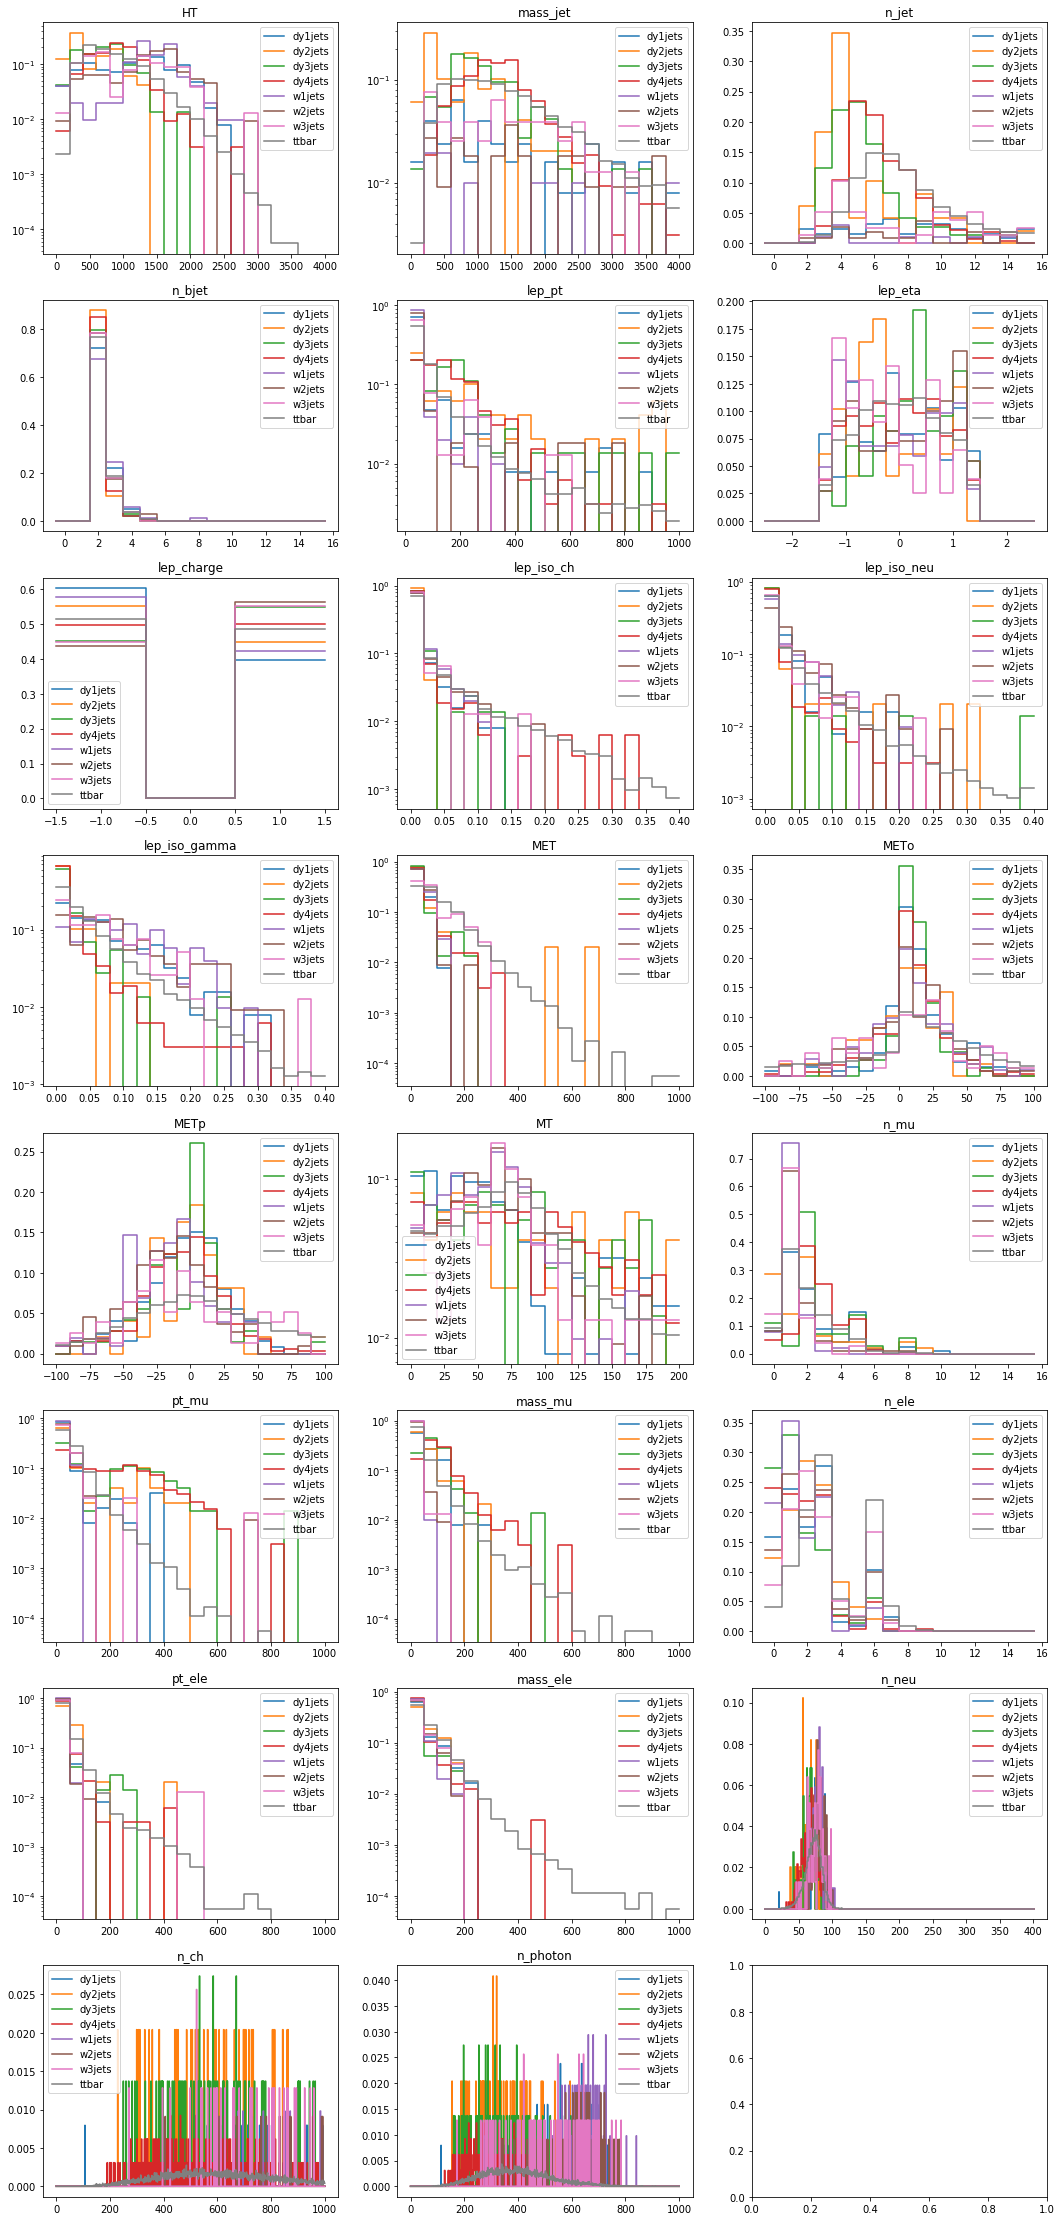

In [38]:
plot_hist(mc_ttbar_hist_a_list, mc_ttbar_key_list, settings_6021, output_file='hist_a_detailed_nostack.pdf')

saving fig to hist.pdf


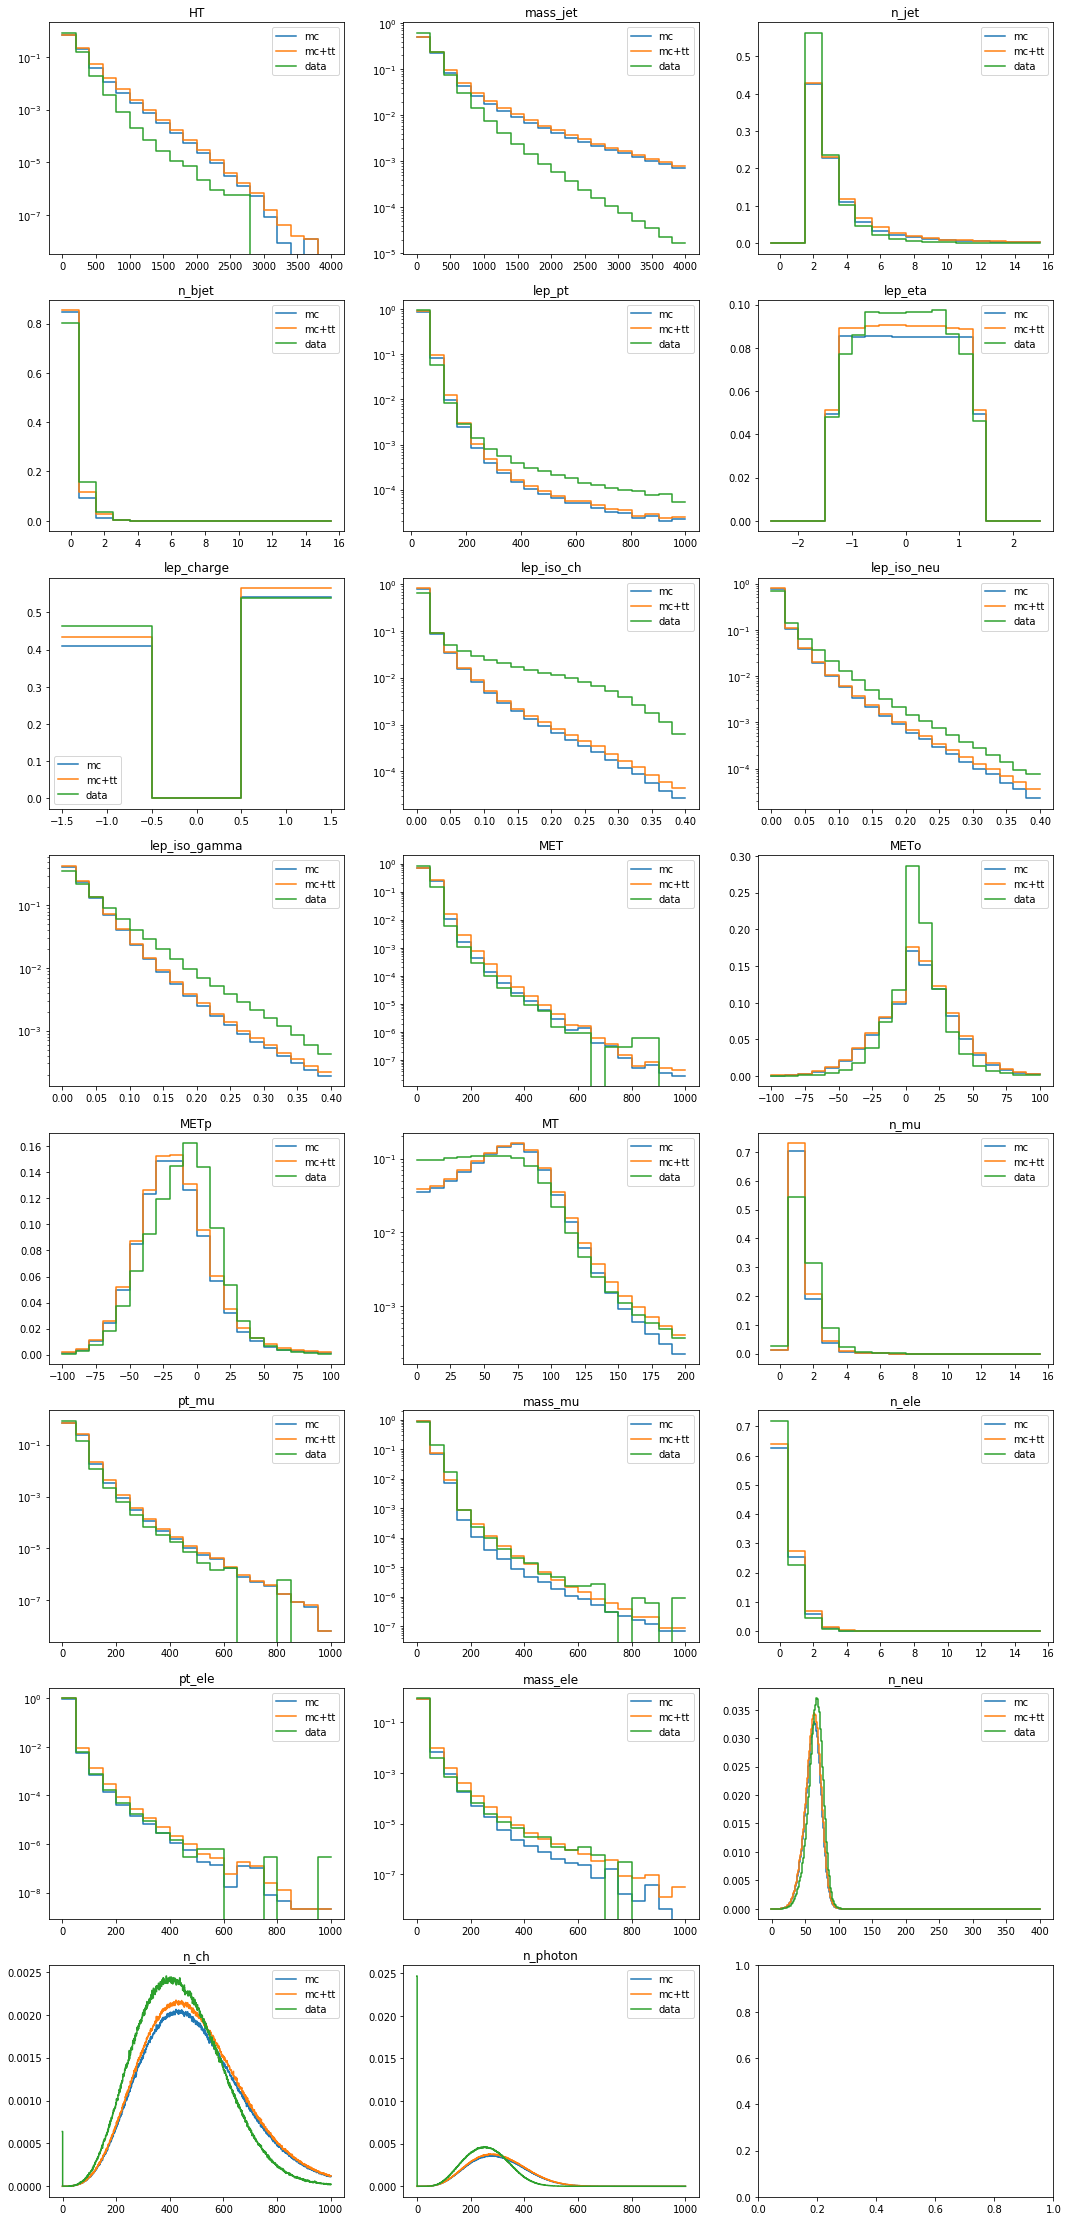

In [39]:
# mc
mc_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets']
mc_hist_list = [sets[key]['hist'] for key in mc_key_list]
mc_hist = sum_hists(mc_hist_list, weights_pres[:-1])
# mc + ttbar
mc_ttbar_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets', 'ttbar']
mc_ttbar_hist_list = [sets[key]['hist'] for key in mc_ttbar_key_list]
mc_ttbar_hist = sum_hists(mc_ttbar_hist_list, weights_pres)

plot_hist([mc_hist, mc_ttbar_hist, data_hist], ['mc', 'mc+tt', 'data'], settings_6021,  output_file='hist.pdf')

saving fig to hist_detailed.pdf


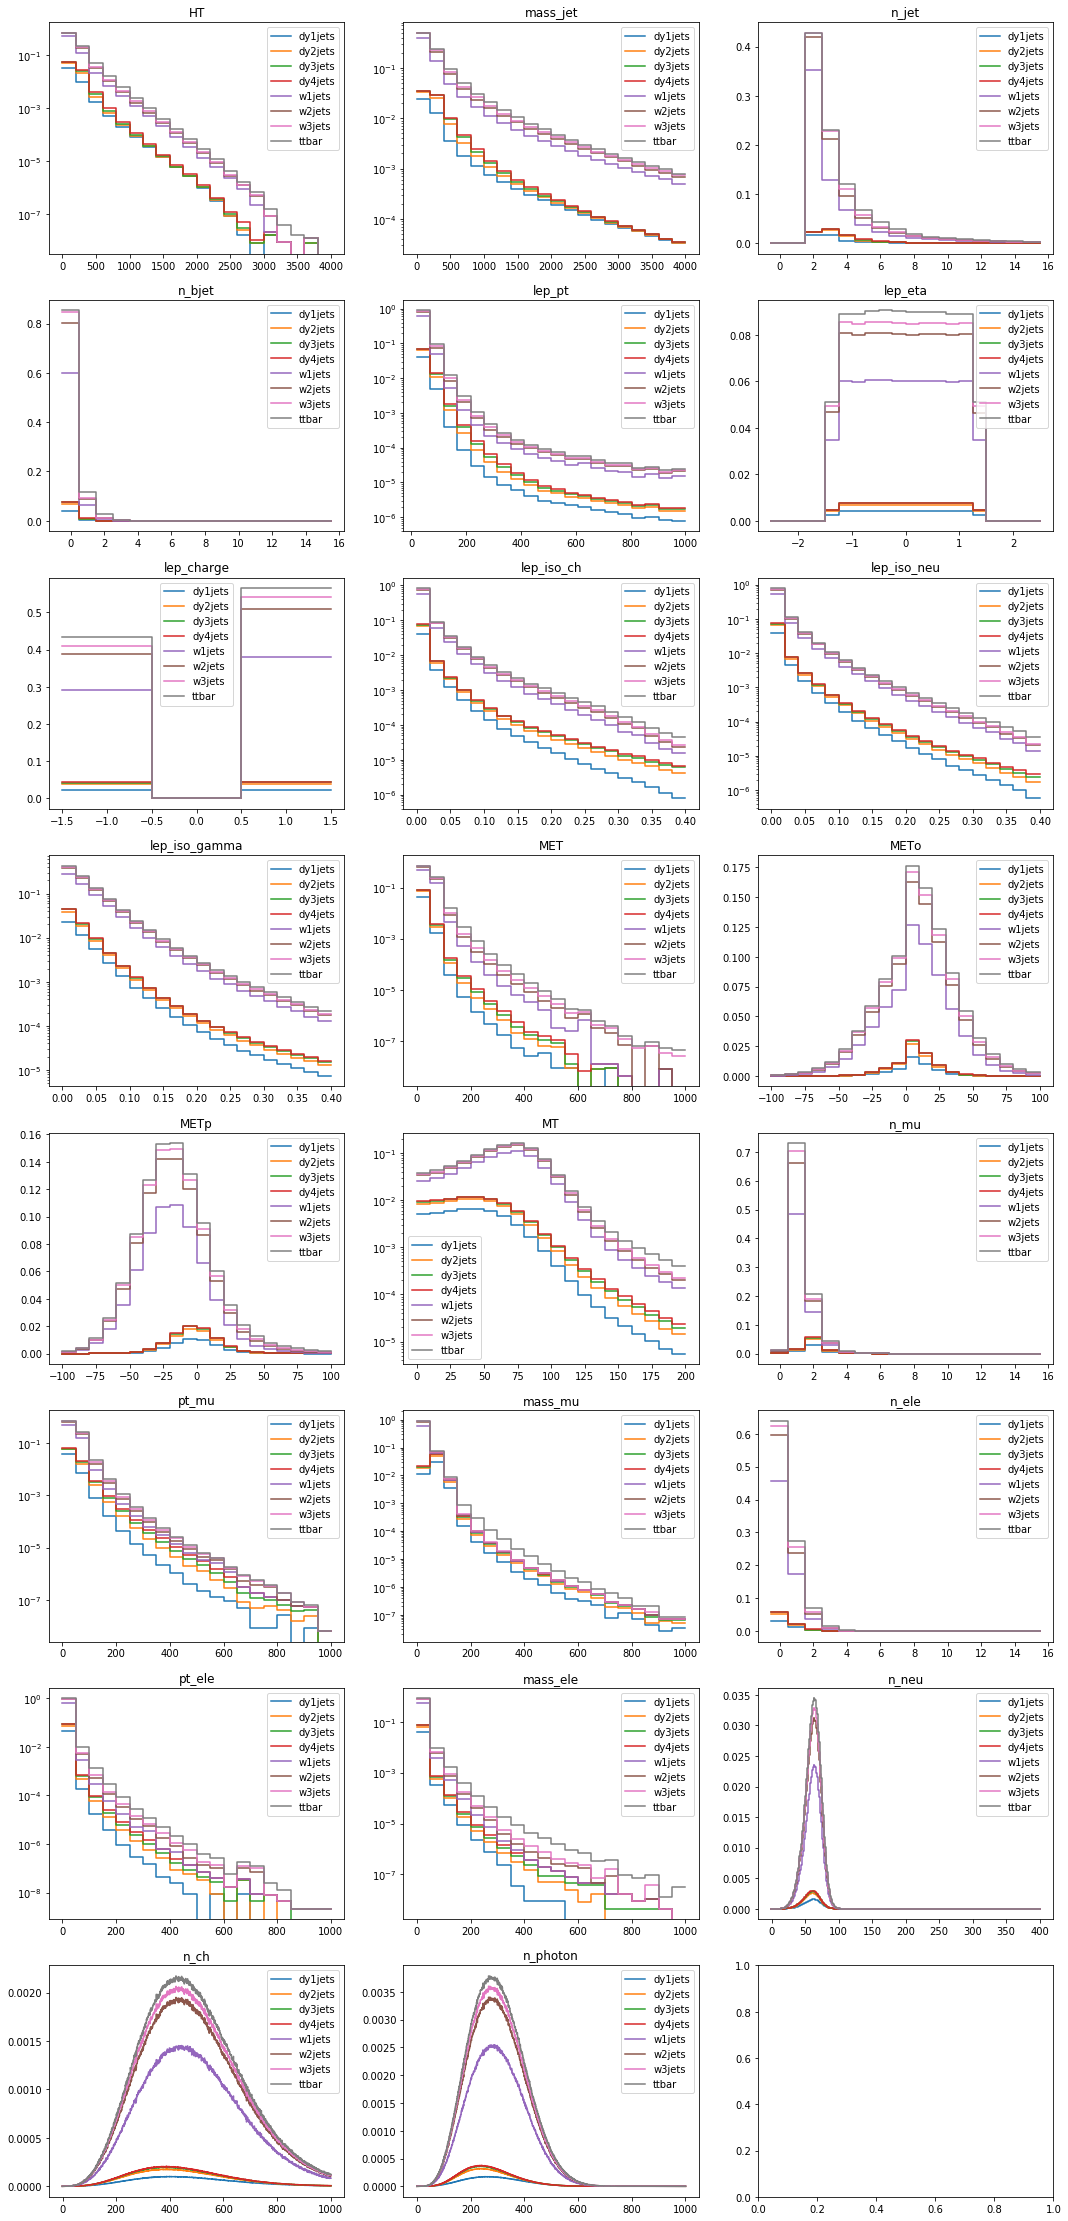

In [40]:
plot_stacked_hist(mc_ttbar_hist_list, mc_ttbar_key_list, weights_pres, settings_6021,  output_file='hist_detailed.pdf')